In [1]:
import numpy as np
import swift_scrape
import os
import matplotlib.pyplot as plt
from matplotlib import ticker
import lmfit as lm
import scipy as sp
import corner
import emcee
import math
import pandas as pd
from lc_lmfit import *

In [2]:
folder='afterglow_data/'
filename='_xray_flux.txt'
GRBs=["050724","060614","070714B","150424A","211211A","211227A","061210","071227"]

### Extracting and Plotting Curves


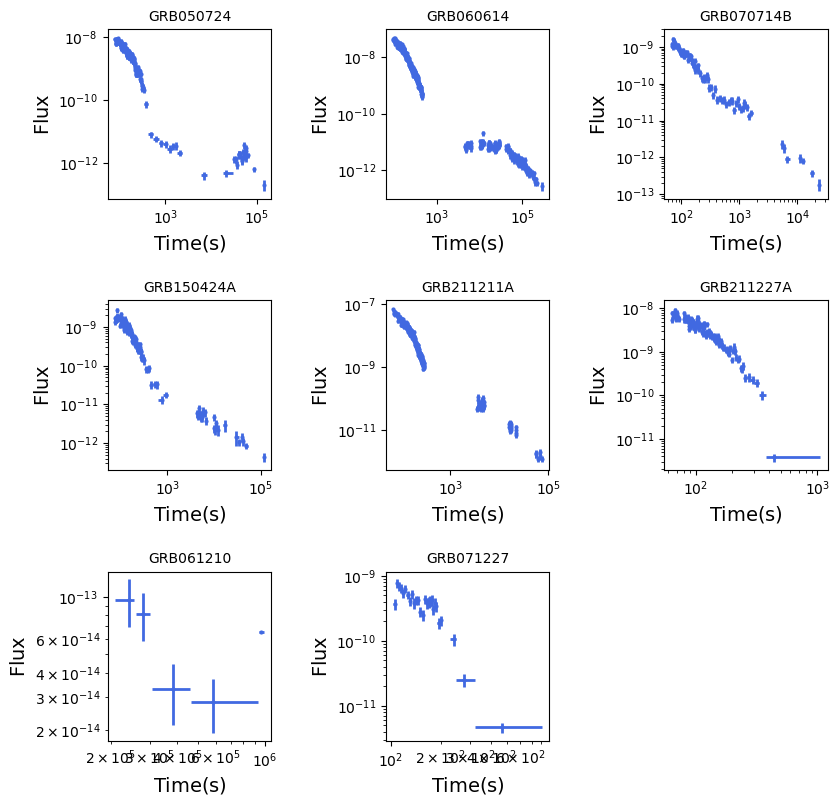

In [41]:
fig=plt.figure(figsize=(8.0,8.0), dpi=100)
fig.patch.set_facecolor('white')
plt.subplots_adjust(top=0.96, bottom=0.07, left=0.07, right=0.97, hspace=0.6,wspace=0.7)

for i in range(len(GRBs)):
    ax1 = fig.add_subplot(3, 3, i+1)
    Time,Time_high,Time_low,Flux,Flux_high,Flux_low=get_individual_curves_log(folder+GRBs[i]+filename)
    ax1.errorbar(Time,Flux,xerr=[Time_low,Time_high],yerr=[Flux_low,Flux_high],fmt='.',color='royalblue',linewidth=2.0,markersize=4.0)
    plt.gca().set_xscale("log")
    plt.gca().set_yscale("log")
    #ax1.set_xlim(1e1,1e5)
    #ax1.set_ylim(1e-14,1e-9)
    ax1.set_xlabel('$\mathrm{Time(s)}$',fontsize=14.)
    ax1.set_ylabel('$\mathrm{Flux}$',fontsize=14.)
    ax1.set_title("GRB"+GRBs[i],fontsize=10)

#xticks = ticker.LogLocator(numticks=4)
#ax1.xaxis.set_minor_locator(xticks)
#ax1.tick_params(axis='x', which='minor', labelsize=7.0)

plt.show()

### GRB i=3

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 8
    # data points      = 28
    # variables        = 2
    chi-square         = 8.26227439
    reduced chi-square = 0.31777978
    Akaike info crit   = -30.1741291
    Bayesian info crit = -27.5097201
[[Variables]]
    alpha_1:    0.80000000 +/- 0.00804842 (1.01%) (init = 0.8)
    amplitude:  4.0000e-09 +/- 3.1441e-10 (7.86%) (init = 4e-09)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha_1, amplitude) = -0.561


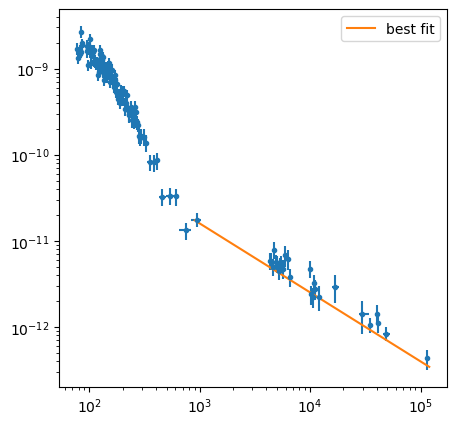

In [151]:
i=3
time,time_high,time_low,flux,flux_high,flux_low =get_individual_curves_log(folder+GRBs[i]+filename)
flux_err = flux_high + flux_low
time_err = time_high + time_low

fit_index = 95


params=lm.Parameters()
# params.add("t_break", min = 100, max = 300, value = 173, vary=False)
# params.add("alpha_2", min = 3.0, max = 9.0, value = 6, vary=False)
params.add("alpha_1", min = 0, max = 5, value = 0.8)
params.add("amplitude", min = 1e-12, max = 1e-6, value = 4e-9)

minner = lm.Minimizer(cost_func_pl, params, fcn_args=(time[fit_index:], flux[fit_index:], time_err[fit_index:], flux_err[fit_index:]))
result = minner.minimize(method="least_squares")

bfit = result.params
# tb = bfit["t_break"].value
# alp2 = bfit["alpha_2"].value
alp1 = bfit["alpha_1"].value
amp = bfit["amplitude"].value

lm.printfuncs.report_fit(result)


x1=np.linspace(900,1.2e5,300)
fig=plt.figure(figsize=(5.0,5.0), dpi=100)
plt.errorbar(time, flux, fmt='.', xerr=[time_low,time_high],yerr=[flux_low,flux_high])
plt.plot(x1,power_law(x1, alp1, amp),label ='best fit')
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.show()

In [149]:
res_refined = lm.minimize(cost_func_pl, method='emcee', burn=1000, steps=5000,
                            params=bfit, is_weighted=True, args=(time[fit_index:], flux[fit_index:], time_err[fit_index:], flux_err[fit_index:]),
                            nwalkers = 100)


100%|██████████| 5000/5000 [00:10<00:00, 491.52it/s]


{'alpha_1': 0.7633958446735991, 'amplitude': 3.3127389558971095e-09}

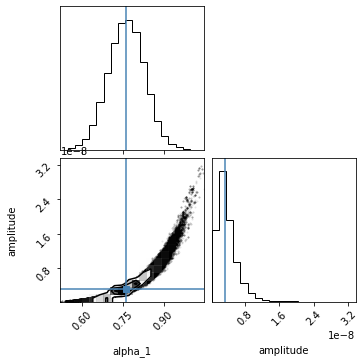

In [150]:
emcee_plot = corner.corner(res_refined.flatchain, labels=res_refined.var_names,
                           truths=list((res_refined.params.valuesdict().values())))

res_refined.params.valuesdict()

### Initial Emission

[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 173
    # data points      = 96
    # variables        = 2
    chi-square         = 112.705282
    reduced chi-square = 1.19899237
    Akaike info crit   = 19.4010976
    Bayesian info crit = 24.5297940
[[Variables]]
    alpha_1:    2.00666436 +/- 0.05941586 (2.96%) (init = 5.16)
    amplitude:  1.5431e-05 +/- 4.6166e-06 (29.92%) (init = 1e-05)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha_1, amplitude) = 0.992


<Figure size 800x800 with 0 Axes>

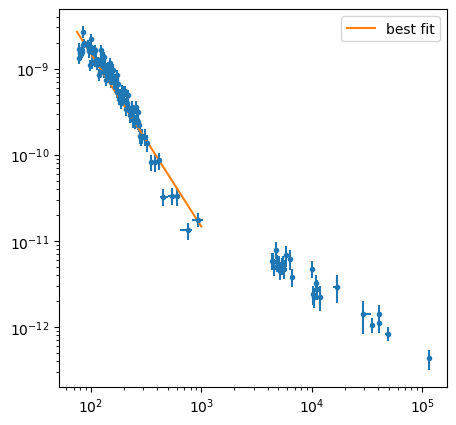

In [182]:
i=3
fig=plt.figure(figsize=(8.0,8.0), dpi=100)
fig.patch.set_facecolor('white')

fit_index = 96
params_ini=lm.Parameters()
params_ini.add("alpha_1", min = 0, max = 10.0, value = 5.16)
params_ini.add("amplitude", min = 1e-7, max = 1e-3, value = 1e-5)

minner_ini = lm.Minimizer(cost_func_pl, params_ini, fcn_args=(time[:fit_index], flux[:fit_index], time_err[:fit_index], flux_err[:fit_index]))
result_ini = minner_ini.minimize(method="nelder")

bfit_ini = result_ini.params
alp1_ini = bfit_ini["alpha_1"].value
amp_ini = bfit_ini["amplitude"].value

lm.printfuncs.report_fit(result_ini)

x1=np.linspace(75,1e3,30)
fig=plt.figure(figsize=(5.0,5.0), dpi=100)
plt.errorbar(time, flux, fmt='.', xerr=[time_low,time_high],yerr=[flux_low,flux_high])
plt.plot(x1,power_law(x1,alp1_ini, amp_ini),label ='best fit')
# plt.errorbar(time[:fit_index], flux[:fit_index], fmt='o')
# plt.plot(x1,power_law(x1, 2.3, 7e-5),label ='best fit')
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.show()

In [184]:
res_refined_ini = lm.minimize(cost_func_pl, method='emcee', burn=1000, steps=5000,
                            params=bfit_ini, is_weighted=True, args=(time[:fit_index], flux[:fit_index], time_err[:fit_index], flux_err[:fit_index]),nwalkers = 100)

100%|██████████| 5000/5000 [00:10<00:00, 470.54it/s]


{'alpha_1': 2.023792756986748, 'amplitude': 1.678774006196279e-05}

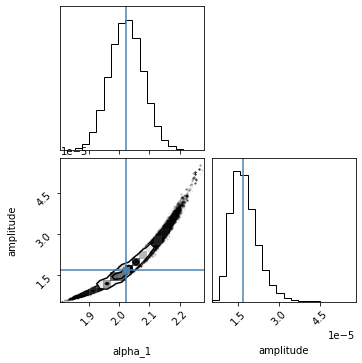

In [185]:
emcee_plot = corner.corner(res_refined_ini.flatchain, labels=res_refined_ini.var_names,
                           truths=list((res_refined_ini.params.valuesdict().values())))

res_refined_ini.params.valuesdict()

In [186]:
df = pd.read_csv("grb_bpl.csv")
pd_row = res_refined.params.valuesdict()
pd_row["GRB Name"] = GRBs[i]
pd_row["GRB Index"] = i
df.iloc[i] = pd_row
df.to_csv("grb_bpl.csv",index=False)

df2 = pd.read_csv("grb_initial_pl.csv")
pd_row2 = res_refined_ini.params.valuesdict()
pd_row2["GRB Name"] = GRBs[i]
pd_row2["GRB Index"] = i
df2.iloc[i] = pd_row2
df2.to_csv("grb_initial_pl.csv",index=False)

### nbroken law


[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 93
    # data points      = 123
    # variables        = 6
    chi-square         = 38.2428527
    reduced chi-square = 0.32686199
    Akaike info crit   = -131.692004
    Bayesian info crit = -114.818897
[[Variables]]
    tb0:        149.595002 +/- 6.11345328 (4.09%) (init = 180)
    tb1:        645.372295 +/- 54.6864578 (8.47%) (init = 850)
    alpha_0:    1.00560242 +/- 0.12795968 (12.72%) (init = 1.3)
    alpha_1:    2.57443550 +/- 0.09413240 (3.66%) (init = 2.7)
    alpha_2:    0.72295536 +/- 0.03983770 (5.51%) (init = 0.6)
    amplitude:  9.2990e-10 +/- 7.5647e-11 (8.13%) (init = 7e-10)
[[Correlations]] (unreported correlations are < 0.100)
    C(tb0, amplitude)     = -0.9193
    C(alpha_0, amplitude) = -0.7873
    C(tb1, alpha_1)       = -0.6616
    C(tb1, alpha_2)       = -0.6478
    C(tb0, alpha_0)       = +0.6087
    C(tb0, alpha_1)       = +0.5275
    C(tb0, tb1)           = -0.2687
    C(alph

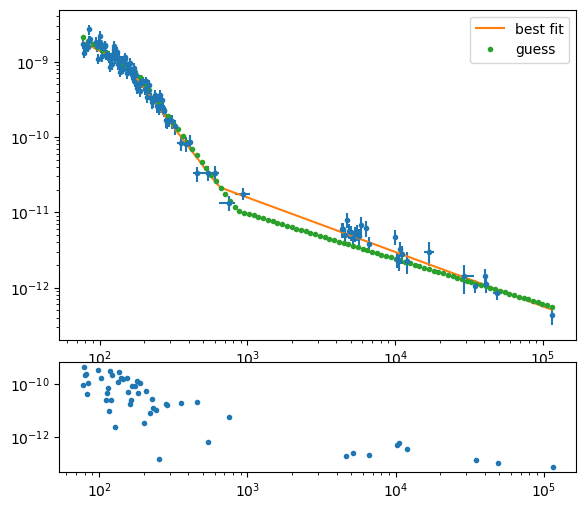

name,value,standard error,relative error,initial value,min,max,vary
tb0,149.595002,6.11345328,(4.09%),180.0,80.0000000,500.000000,True
tb1,645.372295,54.6864578,(8.47%),850.0,500.000000,5000.00000,True
alpha_0,1.00560242,0.12795968,(12.72%),1.3,-10.0000000,10.0000000,True
alpha_1,2.57443550,0.09413240,(3.66%),2.7,-5.00000000,10.0000000,True
alpha_2,0.72295536,0.03983770,(5.51%),0.6,-2.00000000,10.0000000,True
amplitude,9.2990e-10,7.5647e-11,(8.13%),7e-10,4.0000e-10,1.0000e-09,True


In [64]:
i=3
time,time_high,time_low,flux,flux_high,flux_low =get_individual_curves_log(folder+GRBs[i]+filename)
flux_err = flux_high + flux_low
time_err = time_high + time_low

fit_index = 0
n=3
params=lm.Parameters()
params.add("tb0", min = 8e1, max = 5e2, value = 1.8e2)
params.add("tb1", min = 5e2, max = 5e3, value = 8.5e2)
params.add("alpha_0", min = -10, max = 10.0, value = 1.3)
params.add("alpha_1", min = -5.0, max = 10, value = 2.7)
params.add("alpha_2", min = -2, max = 10.0, value = 0.6)
params.add("amplitude", min = 4e-10, max = 1e-9, value = 7e-10)

minner = lm.Minimizer(cost_func_nbpl, params, fcn_args=(time[fit_index:], flux[fit_index:], time_err[fit_index:], flux_err[fit_index:], n), fcn_kws={"orth":False})
result = minner.minimize(method="least_squares")
lm.printfuncs.report_fit(result)

residuals = get_y(result, n, time) - flux

x = np.geomspace(time[0],time[-1],100)
fig, (ax1, ax2) = plt.subplots(2, figsize=(20/3, 6), height_ratios=[3,1])
ax1.errorbar(time, flux, fmt='.', xerr=[time_low,time_high],yerr=[flux_low,flux_high])
ax1.loglog(x, get_y(result, n, x),label ='best fit')
ax1.loglog(x, nbroken_law(x, [1.8e2, 8.5e2], [1.3, 2.7, 0.6], 7e-10),'.',label ='guess')
ax1.legend()
ax2.loglog(time,residuals, '.')
plt.subplots_adjust(hspace=0.1)
plt.show()

result.params

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 55
    # data points      = 123
    # variables        = 4
    chi-square         = 79.8987515
    reduced chi-square = 0.67141808
    Akaike info crit   = -45.0651679
    Bayesian info crit = -33.8164305
[[Variables]]
    tb0:        839.566116 +/- 135.881360 (16.18%) (init = 850)
    alpha_0:    2.00664446 +/- 0.04966608 (2.48%) (init = 2.7)
    alpha_1:    0.77647922 +/- 0.06760132 (8.71%) (init = 0.6)
    amplitude:  2.0931e-11 +/- 6.1714e-12 (29.48%) (init = 2e-11)
[[Correlations]] (unreported correlations are < 0.100)
    C(tb0, amplitude)     = -0.9619
    C(alpha_1, amplitude) = +0.8873
    C(tb0, alpha_1)       = -0.8055
    C(tb0, alpha_0)       = -0.4330
    C(alpha_0, amplitude) = +0.1846


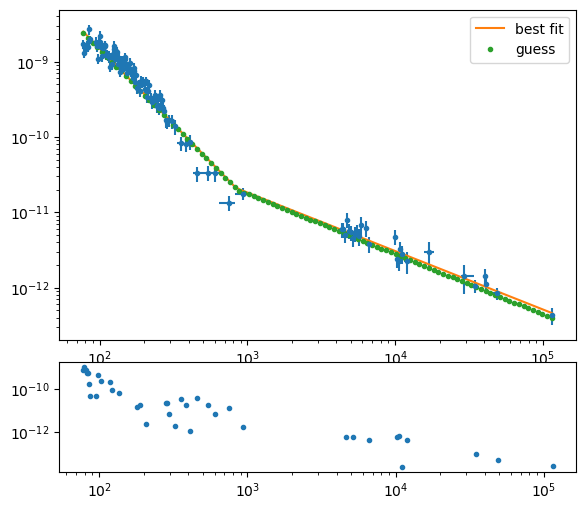

name,value,standard error,relative error,initial value,min,max,vary
tb0,839.566116,135.881360,(16.18%),850.0,500.000000,5000.00000,True
alpha_0,2.00664446,0.04966608,(2.48%),2.7,0.00000000,10.0000000,True
alpha_1,0.77647922,0.06760132,(8.71%),0.6,-5.00000000,5.00000000,True
amplitude,2.0931e-11,6.1714e-12,(29.48%),2e-11,5.0000e-12,9.0000e-11,True


In [65]:
i=3
time,time_high,time_low,flux,flux_high,flux_low =get_individual_curves_log(folder+GRBs[i]+filename)
flux_err = flux_high + flux_low
time_err = time_high + time_low

fit_index = 0
n=2
params=lm.Parameters()
params.add("tb0", min = 5e2, max = 5e3, value = 8.5e2)
params.add("alpha_0", min = 0.0, max = 10, value = 2.7)
params.add("alpha_1", min = -5, max = 5.0, value = 0.6)
params.add("amplitude", min = 5e-12, max = 9e-11, value = 2e-11)

minner = lm.Minimizer(cost_func_nbpl, params, fcn_args=(time[fit_index:], flux[fit_index:], time_err[fit_index:], flux_err[fit_index:], n), fcn_kws={"orth":False})
result = minner.minimize(method="least_squares")
lm.printfuncs.report_fit(result)

residuals = get_y(result, n, time) - flux

x = np.geomspace(time[0],time[-1],100)
fig, (ax1, ax2) = plt.subplots(2, figsize=(20/3, 6), height_ratios=[3,1])
ax1.errorbar(time, flux, fmt='.', xerr=[time_low,time_high],yerr=[flux_low,flux_high])
ax1.loglog(x, get_y(result, n, x),label ='best fit')
ax1.loglog(x, nbroken_law(x, [8.5e2], [2.0, 0.8], 2e-11),'.',label ='guess')
ax1.legend()
ax2.loglog(time,residuals, '.')
plt.subplots_adjust(hspace=0.1)
plt.show()

result.params